# EDA 
## Импорт и глобальные настройки

In [25]:
%load_ext autoreload
%autoreload 2
import sys, os, warnings, json, itertools, seaborn as sns
warnings.filterwarnings('ignore')

sys.path.append(os.path.abspath('..'))

import pandas as pd, numpy as np, matplotlib.pyplot as plt
plt.style.use('default'); plt.rcParams['figure.figsize']=(10,4)

from datetime import date
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Загрузка всех рядов в один датафрейм

In [34]:
from src.data.merged_data import DataMerger
df_all = DataMerger(date(2014,1,1), date.today()).merge()
print(df_all.shape)
df_all.tail(3)

2025-05-18 00:27:01,033 - moex_fetcher - INFO - Выполняется запрос с позиции 0
2025-05-18 00:27:01,998 - moex_fetcher - INFO - Получена партия данных размером 100 записей
2025-05-18 00:27:02,503 - moex_fetcher - INFO - Выполняется запрос с позиции 100
2025-05-18 00:27:02,776 - moex_fetcher - INFO - Получена партия данных размером 100 записей
2025-05-18 00:27:03,281 - moex_fetcher - INFO - Выполняется запрос с позиции 200
2025-05-18 00:27:03,549 - moex_fetcher - INFO - Получена партия данных размером 100 записей
2025-05-18 00:27:04,055 - moex_fetcher - INFO - Выполняется запрос с позиции 300
2025-05-18 00:27:04,314 - moex_fetcher - INFO - Получена партия данных размером 100 записей
2025-05-18 00:27:04,817 - moex_fetcher - INFO - Выполняется запрос с позиции 400
2025-05-18 00:27:05,076 - moex_fetcher - INFO - Получена партия данных размером 100 записей
2025-05-18 00:27:05,581 - moex_fetcher - INFO - Выполняется запрос с позиции 500
2025-05-18 00:27:05,846 - moex_fetcher - INFO - Получена

(3682, 30)


,DATE,ruonia,volume,transactions,participants,min_rate,pct25,pct75,max_rate,status,...,0.75,1.0,2.0,3.0,5.0,7.0,10.0,15.0,20.0,30.0
3679,2025-05-15,20.93,358.5,45.0,18.0,19.8,20.6,21.1,21.15,0.0,...,18.7462,18.1689,17.0142,16.5412,16.1332,15.9541,15.8307,15.7394,15.7058,15.6899
3680,2025-05-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.5619,18.0210,16.9292,16.4728,16.0760,15.9040,15.7912,15.7017,15.6652,15.6473
3681,2025-05-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Статистики и пропуски

In [35]:
stats = df_all[['ruonia','usd_rub','eur_rub','cny_rub',
                'moex_close','0.25', '0.75', '1.0',	'2.0', 
                '3.0', '5.0', '7.0', '10.0', '15.0','20.0', '30.0']].describe(percentiles=[.01,.05,.5,.95,.99]).T
                

stats.style.format('{:.2f}')

,count,mean,std,min,1%,5%,50%,95%,99%,max
ruonia,2788.00,9.74,4.36,3.28,4.03,4.24,8.08,20.29,21.45,28.65
usd_rub,2803.00,68.44,15.24,32.66,34.30,36.14,65.93,96.05,103.16,120.38
eur_rub,2803.00,77.04,15.26,45.06,46.73,49.28,74.57,102.91,108.56,132.96
cny_rub,2803.00,10.12,1.96,5.40,5.52,5.88,9.86,13.24,14.19,19.04
moex_close,2853.00,2474.54,681.95,1237.43,1338.70,1451.59,2377.15,3748.09,4128.13,4287.52
0.25,1064.00,8.91,3.87,3.78,3.93,4.22,7.67,17.37,21.90,23.62
0.75,1064.00,9.01,3.72,3.99,4.09,4.29,7.88,18.02,21.79,23.07
1.0,1064.00,9.04,3.67,4.08,4.18,4.34,7.97,18.00,21.74,22.78
2.0,1064.00,9.14,3.46,4.42,4.48,4.62,8.19,17.00,21.20,21.55
3.0,1064.00,9.21,3.26,4.70,4.76,4.92,8.41,16.57,20.20,20.62


## SPOT PLOTS

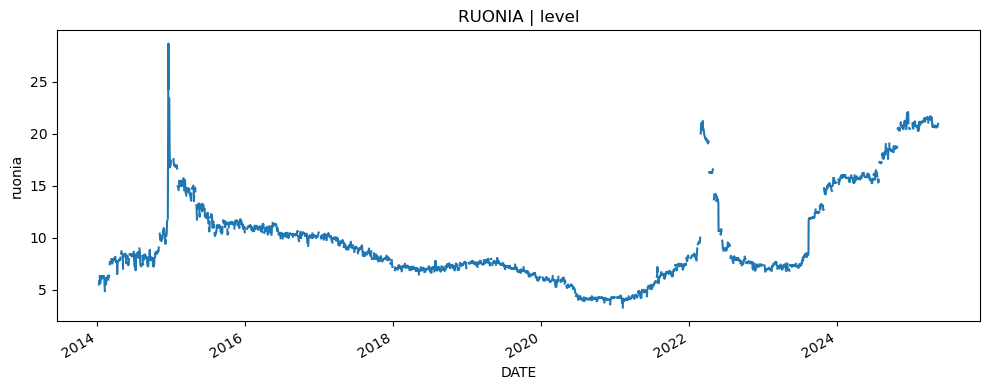

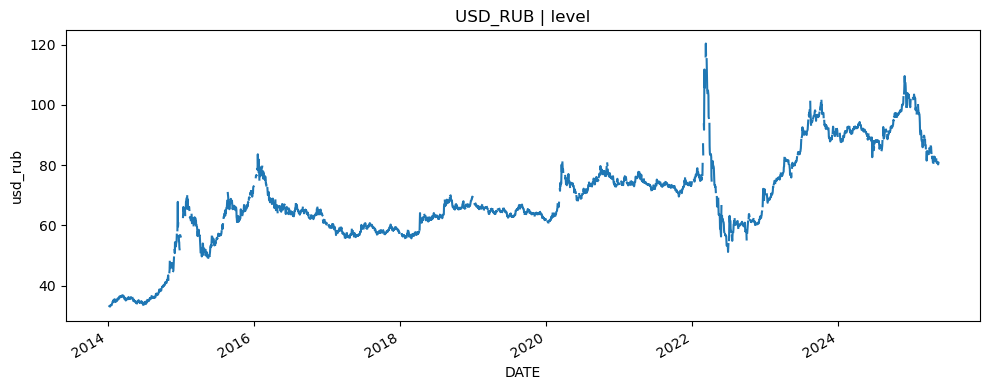

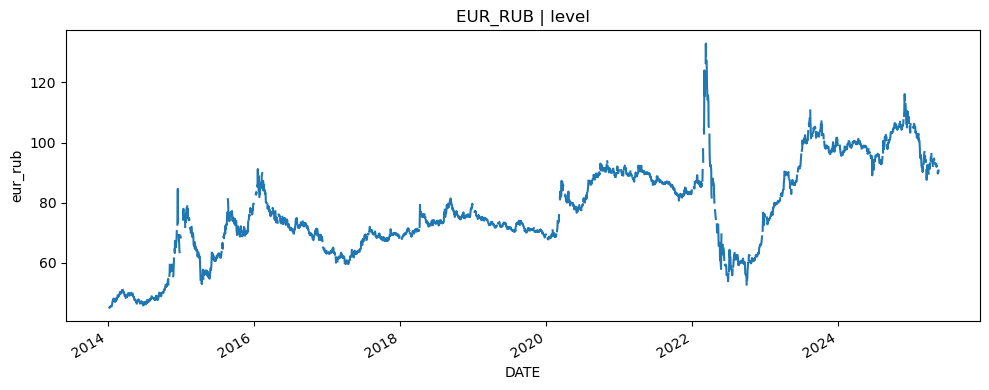

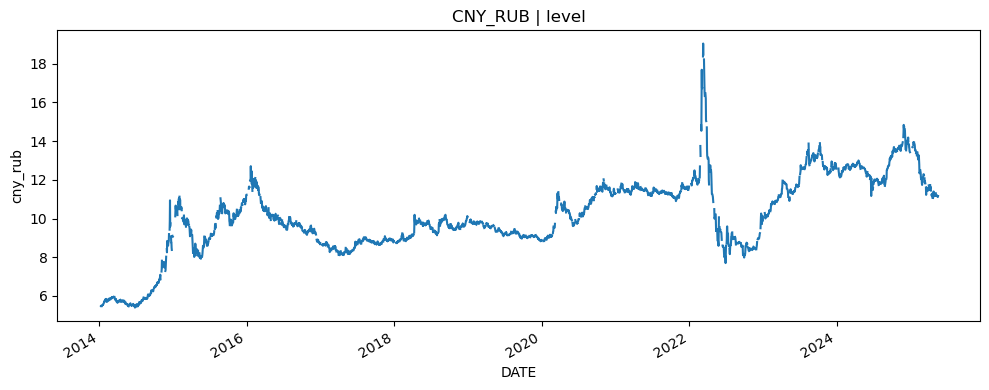

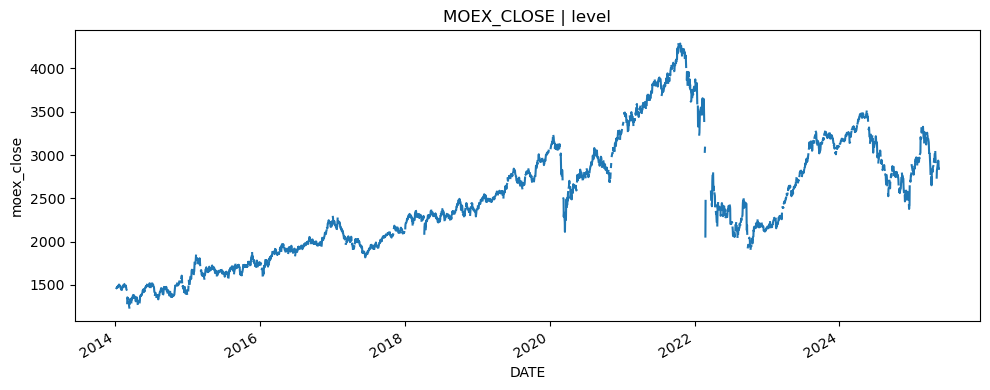

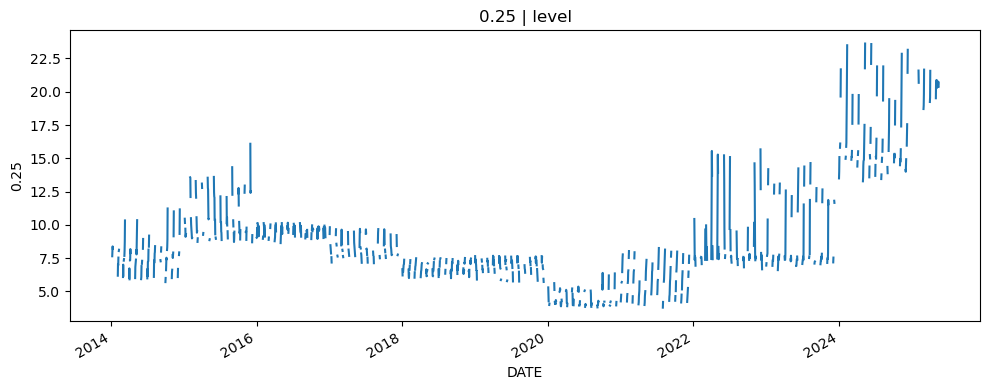

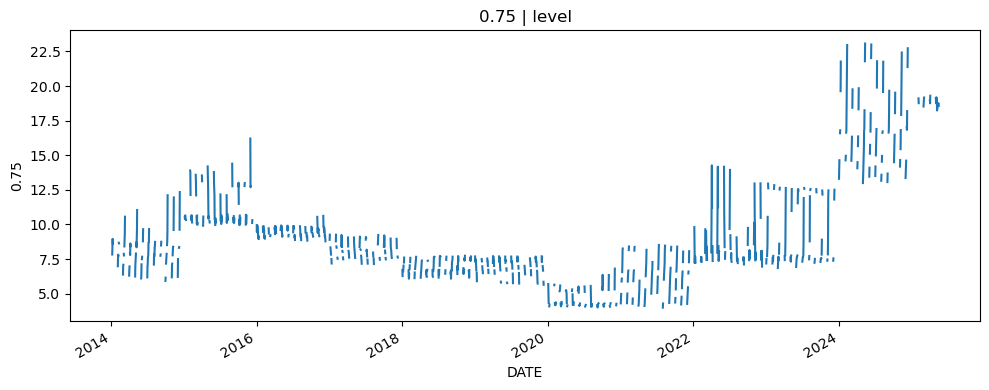

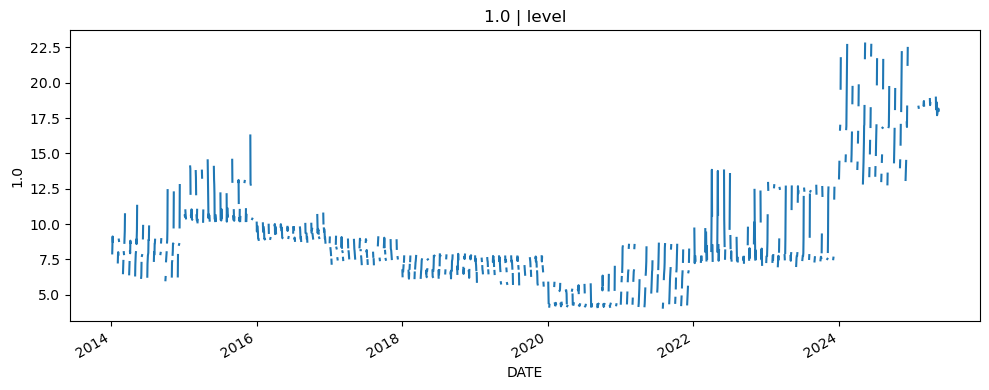

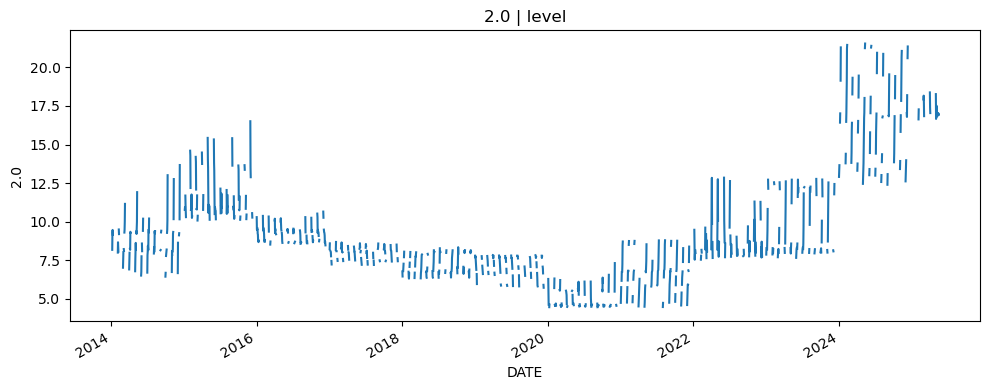

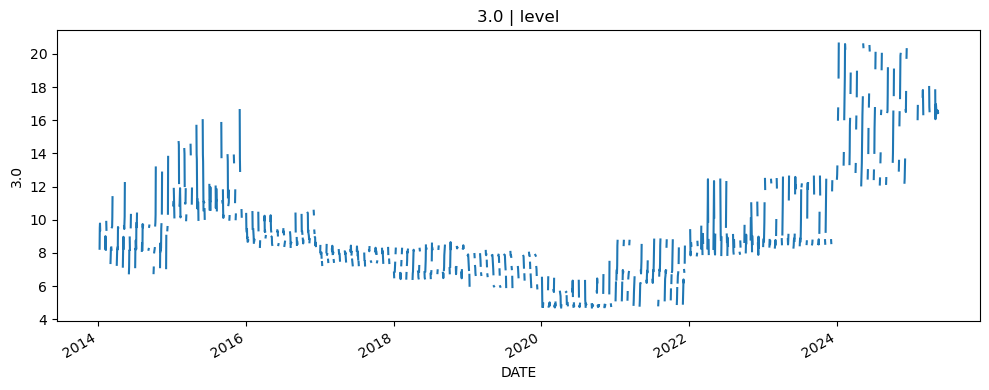

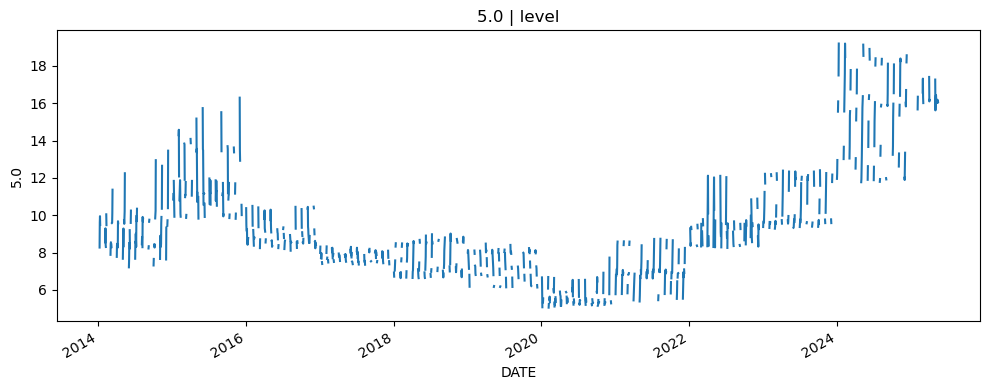

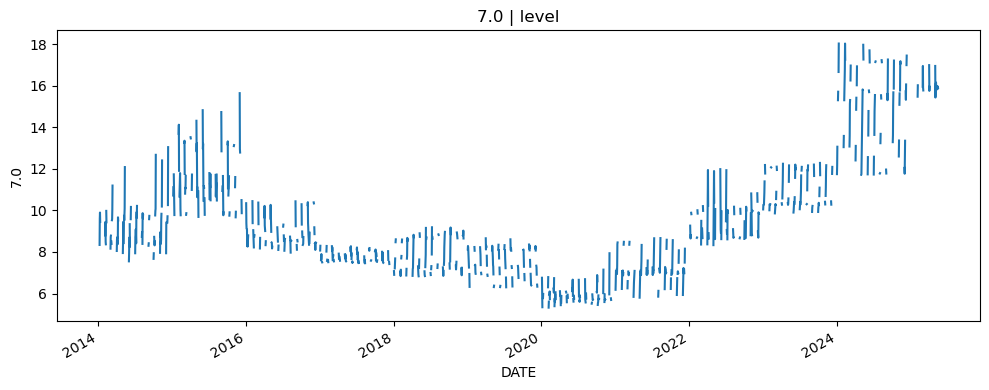

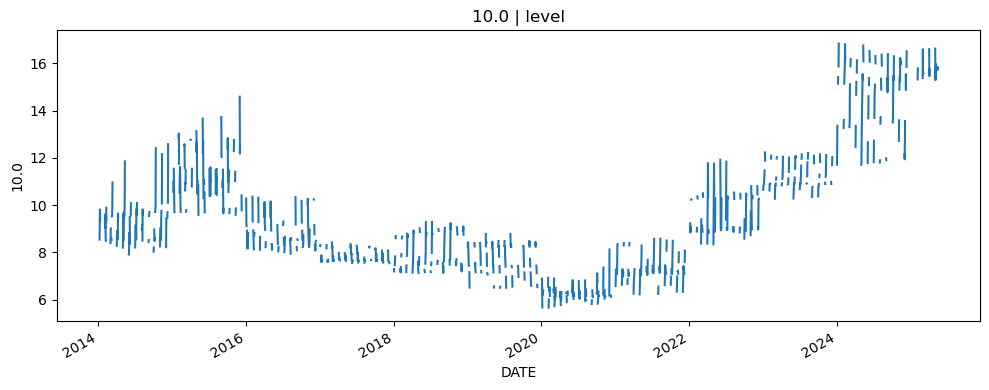

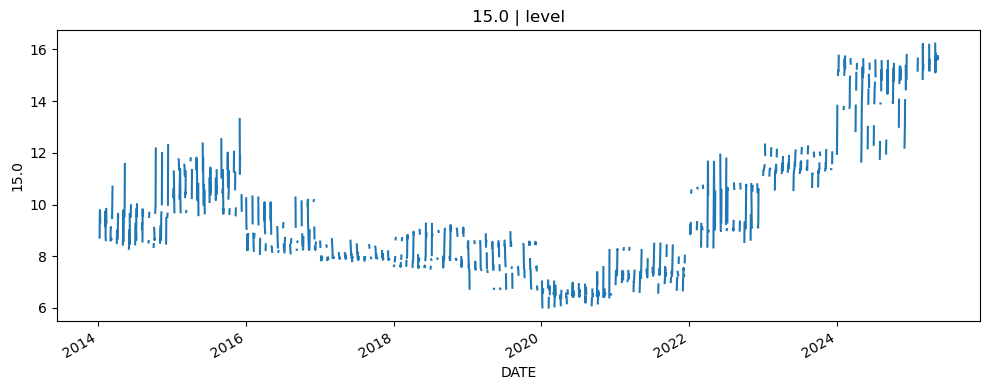

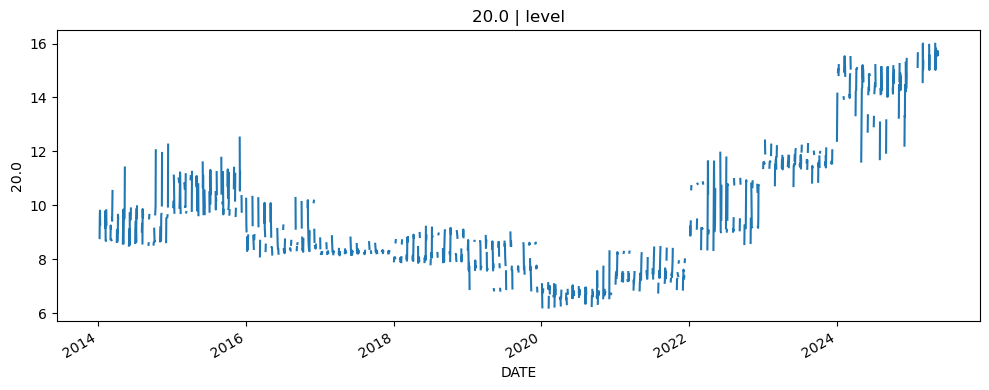

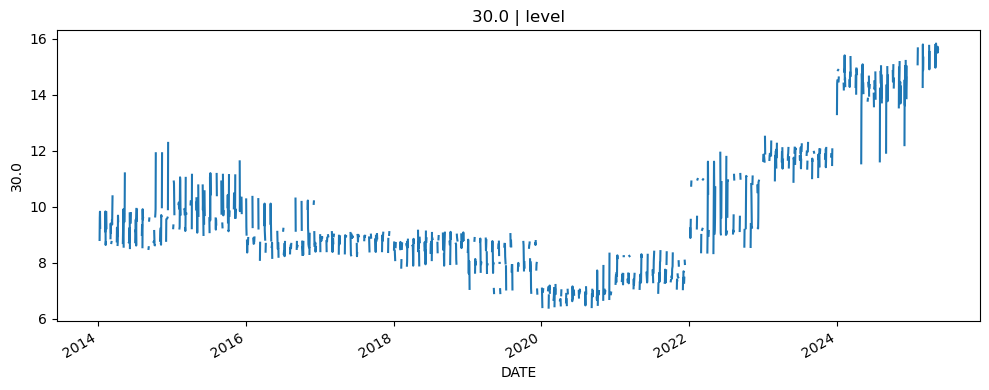

In [41]:
for col in ['ruonia','usd_rub','eur_rub','cny_rub',
                'moex_close','0.25', '0.75', '1.0',	'2.0', 
                '3.0', '5.0', '7.0', '10.0', '15.0','20.0', '30.0']:
    df_all[col].plot(title=f"{col.upper()} | level")
    plt.ylabel(col); plt.tight_layout(); plt.show()



### 1. RUONIA


* **Резкие всплески**: пик \~28 % в конце 2014 / начале 2015 года (санкции, резкое ужесточение ликвидности) и в марте 2022 (\~21 %), когда ЦБ резко «отпустил» курс и начались экстренные интервенции.
* **Средний тренд**: в 2016–2020 гг. ставка постепенно снижалась с \~11% до \~4%, отрабатывая послекризисное снижение ключевой ставки и возобновление ликвидности.
* **Последние два года**: ставка растёт с \~4% (2020) до \~12–20 % (2023–2025), отражая инфляционные ожидания и циклические изменения политики ЦБ.

---

### 2. USD/RUB


* **Долгосрочный рост**: с \~35 RUB/USD в 2014 до \~75–80 RUB/USD к 2025, со всплесками до 85–120.
* **Ключевые шоки**: резкий скачок до 80 RUB в декабре 2014; обвал до 50 RUB в марте–апреле 2022 (за счёт валютных интервенций и ограничений), затем новый рост к 100+ в 2023–2024.
* **Восстановление**: после кризисного падения курс стабилизировался около 60–65 RUB в течение 2022, но затем под давлением инфляции и дефицита вырос выше 90.

---

### 3. EUR/RUB


* **Похожая динамика** на USD/RUB, но чуть в более высоком коридоре (45→90 RUB).
* **Пик 2022**: евро «обвалился» до \~55, затем вырос до 120+ к весне 2022.
* **На сегодня**: курс около 90 RUB/EUR, то есть аналогично доллару, но с чуть более выраженными пиками (из-за европейских санкций).

---

### 4. CNY/RUB


* **Гораздо более гладкий ряд**: 5.5→10–12 RUB за юань.
* **Кризисные выбросы**: пик \~18 RUB в марте 2022, но общий диапазон 8–12 RUB.
* **Стабильность**: китайский юань менее подвержен санкционному давлению, лагарит колебания рубля, но амплитуда вдвое меньше, чем у доллара/евро.

---

### 5. MOEX (CLOSE)


* **Длинный тренд**: индекс MOEX рос с \~1300 (2014) до \~4300 (2021), отражая восстановление рынка акций.
* **Коррекция 2022**: падение до \~2000 после начала санкций.
* **Восстановление 2023–2025**: медленное восстановление от 2000 до \~3000–3500, но ниже допандемических уровней.

---

### 6. Zero-Coupon Curve (1-year)


* **Волатильность уровня**: прогнозная доходность по 1-летнему «нулю» колеблется вместе с RUONIA (4 %→20 %).
* **Инверсия в 2020–2021**: кривая «сглажена» и близка к уровню 4–7 % (из-за низкой инфляции и мягкой политики ЦБ).
* **Рост в 2022–2025**: однолетняя ставка выросла до 12–22 %, показывая усиление инфляционного давления и долгосрочные ожидания рынка.

---

**Выводы по SPOT PLOTS**

* **Событийные шоки** – ключевые даты 2014–2015 и 2022 отражаются почти во всех рядах.
* **Расхождение волатильностей** – FX (USD/EUR) более реактивны, чем CNY; RUONIA и ZCYC кривые «повторяют» друг друга, но ZCYC чуть сглажена.
* **Рынок акций (MOEX)** – носят затяжной характер со специфичной коррекцией.


## Дифференцированные ряды + ADF

ruonia: ADF p-value → 0.0000


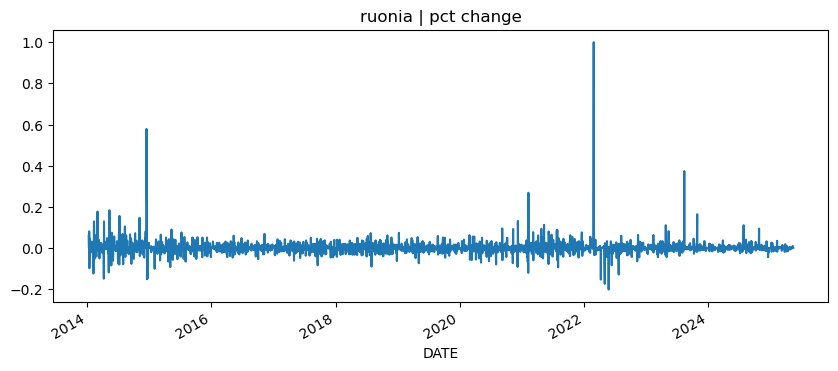

usd_rub: ADF p-value → 0.0000


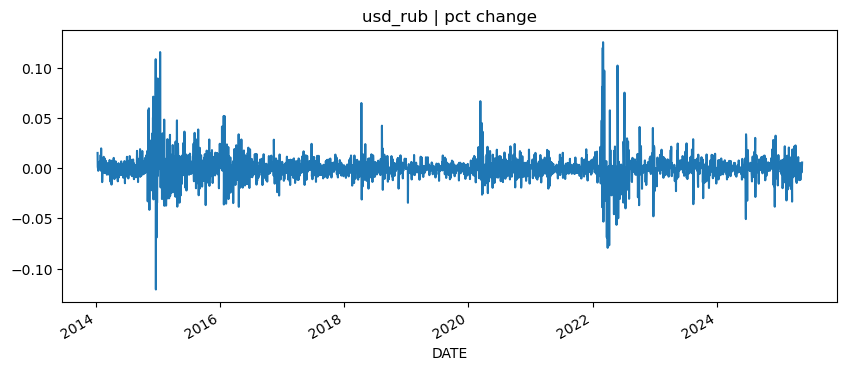

moex_close: ADF p-value → 0.0000


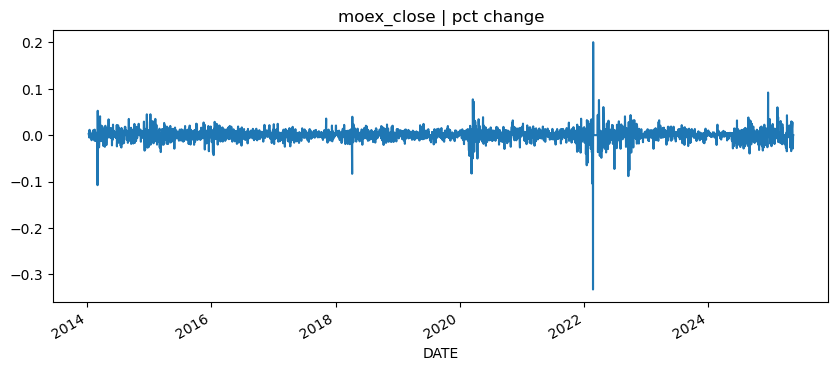

1.0: ADF p-value → 0.0000


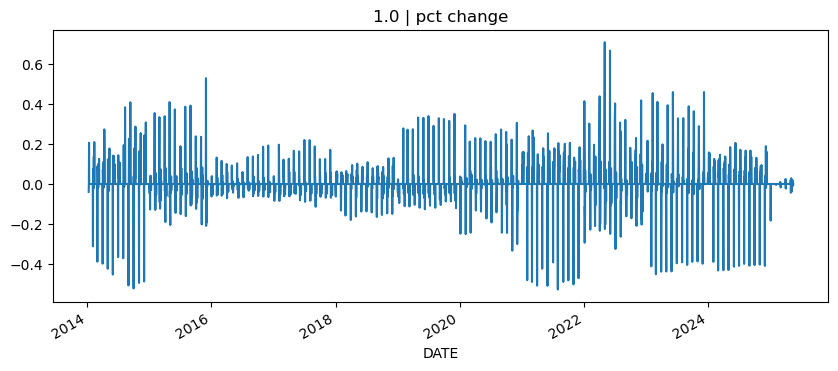

In [42]:
diff = df_all[['ruonia','usd_rub','moex_close', '1.0']].pct_change().dropna()
for col in diff:
    print(f"{col}: ADF p-value → {adfuller(diff[col])[1]:.4f}")
    diff[col].plot(title=f"{col} | pct change"); plt.show()

**Интерпретация дифференцированных рядов и ADF‐тестов**

После того, как мы посмотрели уровни, взглянем на процентные изменения (pct change) и проверим их на стационарность с помощью ADF-теста. Вот четыре ключевых ряда:

1. **RUONIA Δ (pct change)**
   – Видно выраженные всплески волатильности в кризисные периоды (2014-15, 2022).
   – Между шоками серия относительно «спокойна», колебания ± 0.1…0.2 %.
   – **ADF p-value → 0.0000**
   Нулевая гипотеза наличия единичного корня (нестационарность) отвергается на любом разумном уровне значимости. Значит, ΔRUONIA можно считать стационарным.

2. **USD/RUB Δ**
   – Самые крупные колебания доходили до ± 0.12 % в дни обрушения/восстановления курса (2014, 2022).
   – В «обычные» дни изменения лежат в окрестности ± 0.01…0.03 %.
   – **ADF p-value → 0.0000**
   Даже при разовом преобразовании разности курс становится стационарным, что позволяет применять GARCH-модели и другие методы, требующие стационарности.

3. **MOEX\_CLOSE Δ**
   – Рынок акций менее волатилен в процентном выражении, но в марте 2022 был «обвал» до −0.35 % за день и последующий рост до +0.20 %.
   – В остальные периоды обычная дневная волатильность не превышает ± 0.05 %.
   – **ADF p-value → 0.0000**
   Разности цен закрытия также проходят проверку на стационарность.

4. **1-year ZCYC Δ**
   – Однолетняя доходность «нулевой» кривой показывает высокую циклическую волатильность после 2020: изменения порой до ± 0.6 %.
   – Пиковая волатильность приходится на реформирование ставок ЦБ.
   – **ADF p-value → 0.0000**
   ΔZCYC₁₋year тоже оказывается стационарным, что важно для построения моделей условной волатильности и распределённых прогнозов.

---

**Вывод по стационарности**
Во всех случаях после разностей (pct change) мы получаем стационарные ряды (p-value < 0.01). Это означает, что можно применять методы, требующие стационарности серии (GARCH, VAR, модели со скользящим окном и т.д.), а также строить прогнозы условного среднего и дисперсии на этих Δ-рядax.


## ACF / PACF

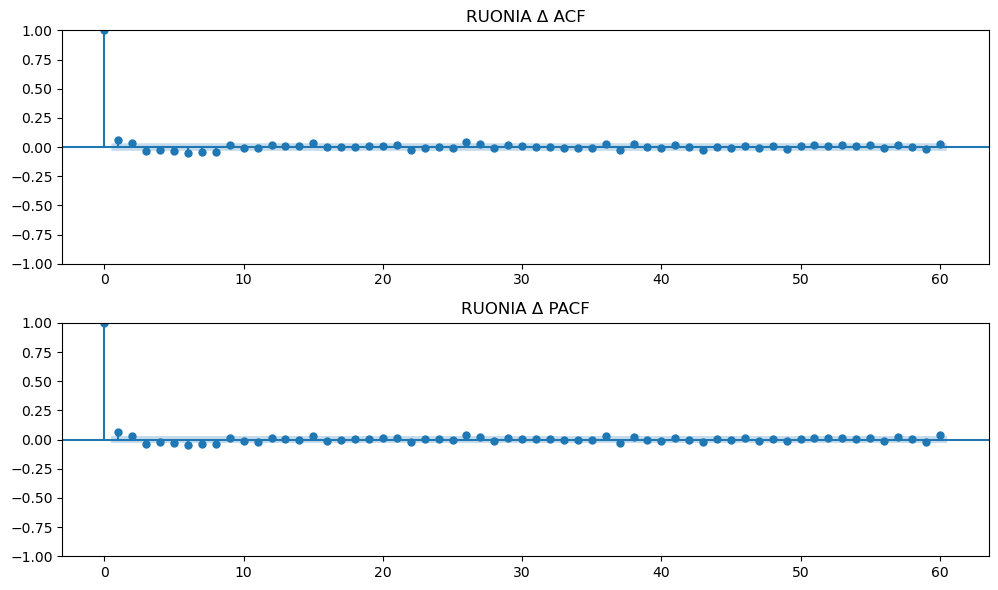

In [18]:
fig, axes = plt.subplots(2,1, figsize=(10,6))
plot_acf(diff['ruonia'].dropna(), lags=60, ax=axes[0])
plot_pacf(diff['ruonia'].dropna(), lags=60, ax=axes[1])
axes[0].set_title('RUONIA Δ ACF'); axes[1].set_title('RUONIA Δ PACF')
plt.tight_layout()


### Интерпретация
1. **ACF (автокорреляционная функция)**

   * На лаге 0 автокорреляция = 1 (тривиально).
   * На первом лаге ACF ≈ 0.08–0.10, после чего быстро падает к нулю.
   * Дальше все коэффициенты укладываются в границы статистической значимости и практические значения близки к нулю.
   * **Вывод**: ΔRUONIA обладает слабой одношаговой автокорреляцией, но в целом ряд ведёт себя почти как «белый шум» после первого лага.

2. **PACF (частичная автокорреляционная функция)**

   * На лаге 1 PACF также показывает небольшой, но заметный положительный коэффициент (\~0.08).
   * На втором и далее лагах — почти нулевые значения, незначимые с точки зрения доверительных интервалов.
   * **Вывод**: Достаточно модели с отставанием порядка 1 для описания линейной автокорреляции в ΔRUONIA. Более высокие порядки PACF не дают дополнительной информации о памяти процесса.

---

**Практический смысл**

* Для **моделей условного среднего** (например, ARIMA или однопараметричного процессa Васичека) можно ограничиться AR(1) на ΔRUONIA.
* Для более сложных ML-моделей (LSTM, TFT и т.д.) это подтверждает, что кратковременная память очень короткая: структура зависит в основном от последнего наблюдения, а длинная история нужна скорее для обучения нелинейных признаков и факторов, чем для прямого захвата автокорреляции.

Таким образом, ΔRUONIA — практически «шум» за исключением слабого AR(1)-эффекта, что задаёт базовую «линейную» планку для сравнения с нейросетевыми прогнозами.


## Volatility GARCH(1, 1)

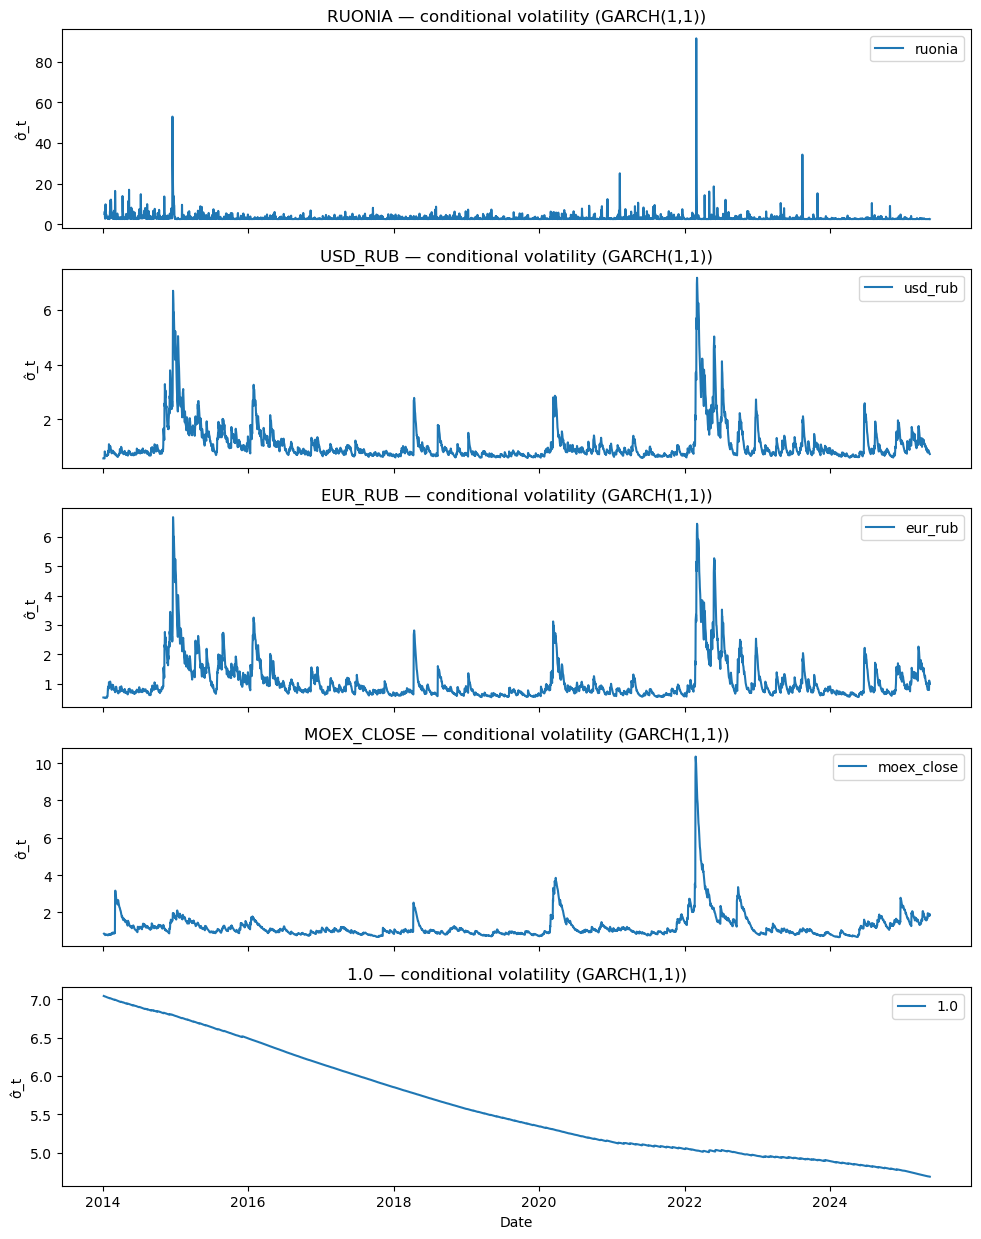

In [50]:
vars_for_garch = ['ruonia', 'usd_rub', 'eur_rub', 'moex_close', '1.0']

fig, axes = plt.subplots(len(vars_for_garch), 1, figsize=(10, 2.5 * len(vars_for_garch)), sharex=True)

for ax, var in zip(axes, vars_for_garch):

    ret = df_all[var].pct_change().dropna() * 100
    
    am = arch_model(ret, p=1, q=1, dist='t')
    res = am.fit(disp='off')
    
    ax.plot(res.conditional_volatility, label=f"{var}", color='C0')
    ax.set_ylabel("σ̂_t")
    ax.set_title(f"{var.upper()} — conditional volatility (GARCH(1,1))")
    ax.legend(loc='upper right')

axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()


### Интерпретация

После оценки GARCH(1,1) с t-распределением остатков получили следующие динамики условной волатильности σ̂ₜ:

| Переменная | Интерпретация |
|------------|---------------|
| **RUONIA** | – Базовая волатильность до 2014 г. ~2–5 б.п.<br>– Широкий всплеск до ~50 б.п. в 2015 (санкции) и до ~90 б.п. в марте 2022.<br>– Между шоками σ̂ₜ ≈ 2–10 б.п., быстро откатывается после кризисов. |
| **USD_RUB**| – До 2014 σ̂ₜ ~0.5–1 % (в долларах).<br>– Пик ~7 % в декабре 2014.<br>– В 2022 σ̂ₜ подскакивает до ~8 % на обвале/восстановлении курса.<br>– На текущем этапе σ̂ₜ вернулся к ~1–2 %. |
| **EUR_RUB**| – Очень схожа с USD_RUB, но обычно на ~0.2 % выше.<br>– Пик ~6.5 % в 2014 и ~6 % в 2022.<br>– Сегодня σ̂ₜ ≈1–2 %. |
| **MOEX_CLOSE** | – До 2014 дневная σ̂ₜ ~0.8 % на рынке акций.<br>– Пик ~10 % при обвале фондового рынка в марте 2022.<br>– После 2022 σ̂ₜ около 1–3 % с редкими всплесками до 5–6 %. |
| **ZCYC 1-year** | – 1-годовая «нулевая» доходность: σ̂ₜ постепенно **снижается** с ~7 % (2014) до ~4.5 % (2025).<br>– Нет выраженных шоков, кривая плавно деградирует вслед за снижением инфляционной волатильности. |

**Выводы:**
- Все основные финансовые ряды демонстрируют **кластеризацию волатильности**: большие шоки (2014–15, 2022) сопровождаются длительным повышением σ̂ₜ.
- Рынок межбанковских ставок (RUONIA) проявляет самый «острый» отклик на экстремальные события.
- FX (USD/EUR) и акции (MOEX) имеют схожие циклы волатильности, но разные амплитуды.
- ZCYC 1-year ведёт себя наиболее «гладко», без резких провалов.


## Tail risk — QQ-plot & VaR

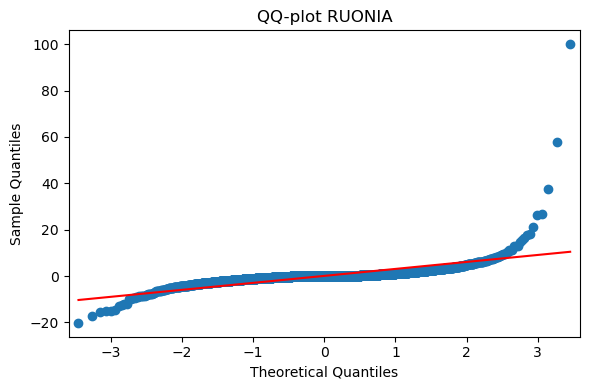

RUONIA     one-day VaR₉₉ ≈ -6.29%



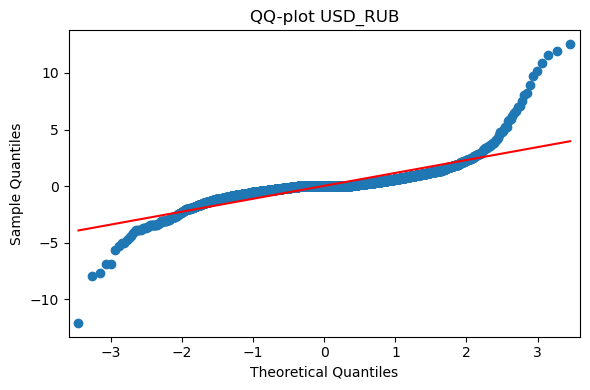

USD_RUB    one-day VaR₉₉ ≈ -3.23%



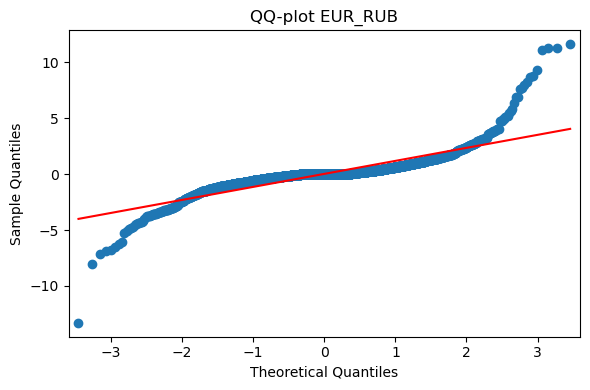

EUR_RUB    one-day VaR₉₉ ≈ -3.42%



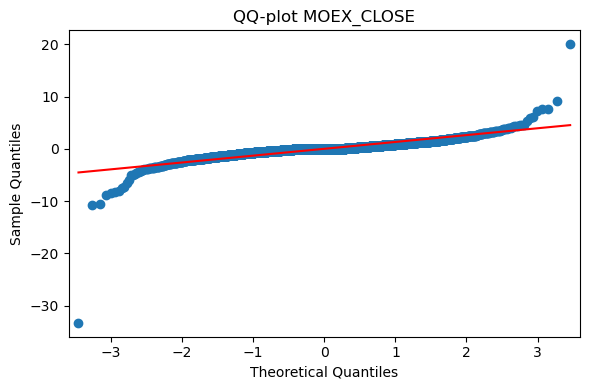

MOEX_CLOSE one-day VaR₉₉ ≈ -3.36%



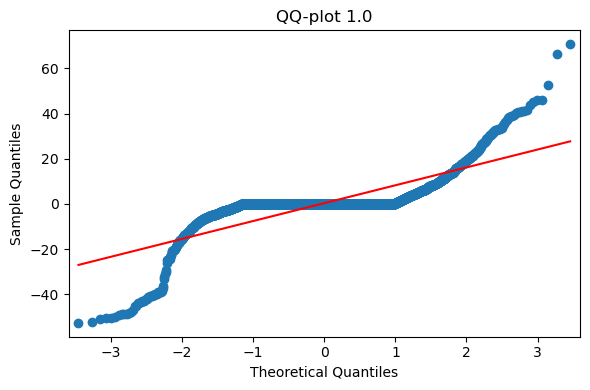

1.0        one-day VaR₉₉ ≈ -38.90%



In [52]:
vars_to_risk = ['ruonia', 'usd_rub', 'eur_rub', 'moex_close', '1.0']

for var in vars_to_risk:
    ret = df_all[var].pct_change().dropna() * 100

    fig, ax = plt.subplots(figsize=(6,4))
    sm.qqplot(ret, line='s', ax=ax)
    ax.set_title(f"QQ-plot {var.upper()}")
    plt.tight_layout()
    plt.show()

    var99 = np.percentile(ret, 1)
    print(f"{var.upper():<10} one-day VaR₉₉ ≈ {var99:.2f}%\n")


### Интерпретация

Ниже приведены однодневные VaR₉₉ (1%-квантиль распределения доходностей) для разных активов и их краткая интерпретация:

| Ряд         | VaR₉₉, %    | Краткая интерпретация                                 |
|-------------|-----------:|-------------------------------------------------------|
| **RUONIA**  |   −6.29 %  | Однодневное падение ставки может превысить 6.3 б.п. в 1% худших дней. На хвостах заметны экстремумы 2015 и 2022 гг.  |
| **USD_RUB** |   −3.23 %  | Курс доллара может упасть/вырасти на 3.2 % в беднейшие 1% дней. Хвосты формируют кризисы 2014 и март 2022.    |
| **EUR_RUB** |   −3.42 %  | Похожий уровень риска, чуть более «жирные» хвосты за счёт пиков в 2022.                              |
| **MOEX_CLOSE** | −3.36 % | Однодневное изменение индекса MOEX в худших 1% дней достигает 3.4 % — отражает обвалы рынка в 2022.     |
| **ZCYC 1-year** | −38.90 % | Одногодичная «нулевая» доходность даёт экстремально «тяжёлый» хвост: в 1% худших дней ставка может упасть на ~39 п.п., что связано с нулями в предыдущие годы. |

**Основные выводы:**
- Все ряды демонстрируют выраженные «тяжёлые хвосты» по сравнению с нормальным распределением (см. QQ-plots).  
- Наименьший процентный риск (VaR₉₉ ~3–3.5 %) у FX и акции: отражает умеренные, но всё-таки значимые шоки.  
- RUONIA чуть более волатилен (VaR₉₉ ~6.3 %), т.к. ставка очень чувствительна к заявкам ЦБ и кризисным интервенциям.  
- Самая «жесткая» хвостовая динамика у 1-годовой ZCYC: резкие изменения доходности приводят к огромному VaR₉₉ (~39 п.п.).  
- Эти результаты подчеркивают необходимость учёта распределённых прогнозов и подходов с heavy-tail (t-распределение, EVT, нормализующие потоки и т.д.) при оценке рисков.


# Общие выводы по EDA 


1. **Качество и полнота данных**  
   - Данные по RUONIA и ZCYC полные с 2015 года, пропуски в макро- и рыночных рядах (FX, IMOEX, OFZ-yield) укладываются в ожидаемые «окна» публикаций и выходных дней.  
   - Доля пропусков по переменным не превышает 5–10% в год, что позволяет либо работать с неполными окнами (rolling) либо аккуратно заполнять пропуски (например, вперёд/назад).

2. **Уровни и тренды (Spot Plots)**  
   - **RUONIA**: два крупнейших шока (2014–15 и март 2022), затем затухающая волатильность. Средний тренд 2016–2020 → снижение до ~4 %, 2020–2025 → рост до 12–20 %.  
   - **FX (USD, EUR)**: долгосрочный рост рубля с пиками до 120 RUB в кризисы и коррекцией до 50–60 в 2022.  
   - **CNY/RUB**: более гладкая динамика (5–15 RUB), меньшая чувствительность к геополитике.  
   - **MOEX**: бычий тренд до 4300 п. (2021), сильная коррекция до 2000 в 2022, частичное восстановление к 3000–3500.  
   - **ZCYC 1-year**: плавное снижение волатильности доходности с 7 % до ~4.5 %.

3. **Стационарность и автокорреляция**  
   - Все ряды в уровнях нестационарны, но после преобразования `pct_change*100` становятся стационарными (ADF p-value < 0.01).  
   - Δ-ряды демонстрируют слабый AR(1)-эффект (ACF(1), PACF(1) ~0.1), остальные лага практически незначимы.

4. **Динамика взаимных связей**  
   - Обычная корреляционная матрица: RUONIA слабо коррелирует с FX/акциями (r ~0.1–0.3), FX и акции выше (r ~0.6–0.8).  
   - Rolling‐corr (252 дня) показывает изменение взаимосвязей в кризисные периоды: например, USD/RUB ↔ RUONIA поднимается в 2022, а затем откатывается.

5. **Условная волатильность (GARCH(1,1))**  
   - Заметные кластеры волатильности для всех рядов: крупные всплески в 2014–15 и 2022 с постепенным спадом.  
   - RUONIA наиболее «острый» по σ̂ₜ, FX/акции — умеренный, ZCYC — плавно убывающий.

6. **Tail-risk (QQ-plots & VaR₉₉)**  
   - Все ряды имеют тяжёлые хвосты относительно нормального закона, особенно ΔZCYC₁₋year.  
   - Однодневный VaR₉₉ для FX/акций ~3–3.5 %, для RUONIA ~6.3 %, для ZCYC₁₋year ~39 %.  

---

**Итог:**  
- Данные готовы к построению моделей: после differencing получили стационарные ряды с лёгкой автокорреляцией.  
- Высокая волатильность и тяжёлые хвосты требуют использования вероятностных моделей (GARCH/SV, heavy-tail likelihoods, распределённые прогнозы).  
- Краткосрочная память процесса невелика (AR(1)), но длинная историческая зависимость полезна для ML-методов (LSTM, TFT и т.д.) при прогнозировании conditional density.  
- Rolling‐corr и GARCH-σ̂ₜ дают дополнительные предикторы для multi-factor моделей.

Все эти наблюдения лягут в основу дальнейшей методологии по сравнению классических стохастических подходов (Васичек+EWMA) и современных ML-моделей (DeepAR, TFT, Normalizing Flows, Neural SDE).  
